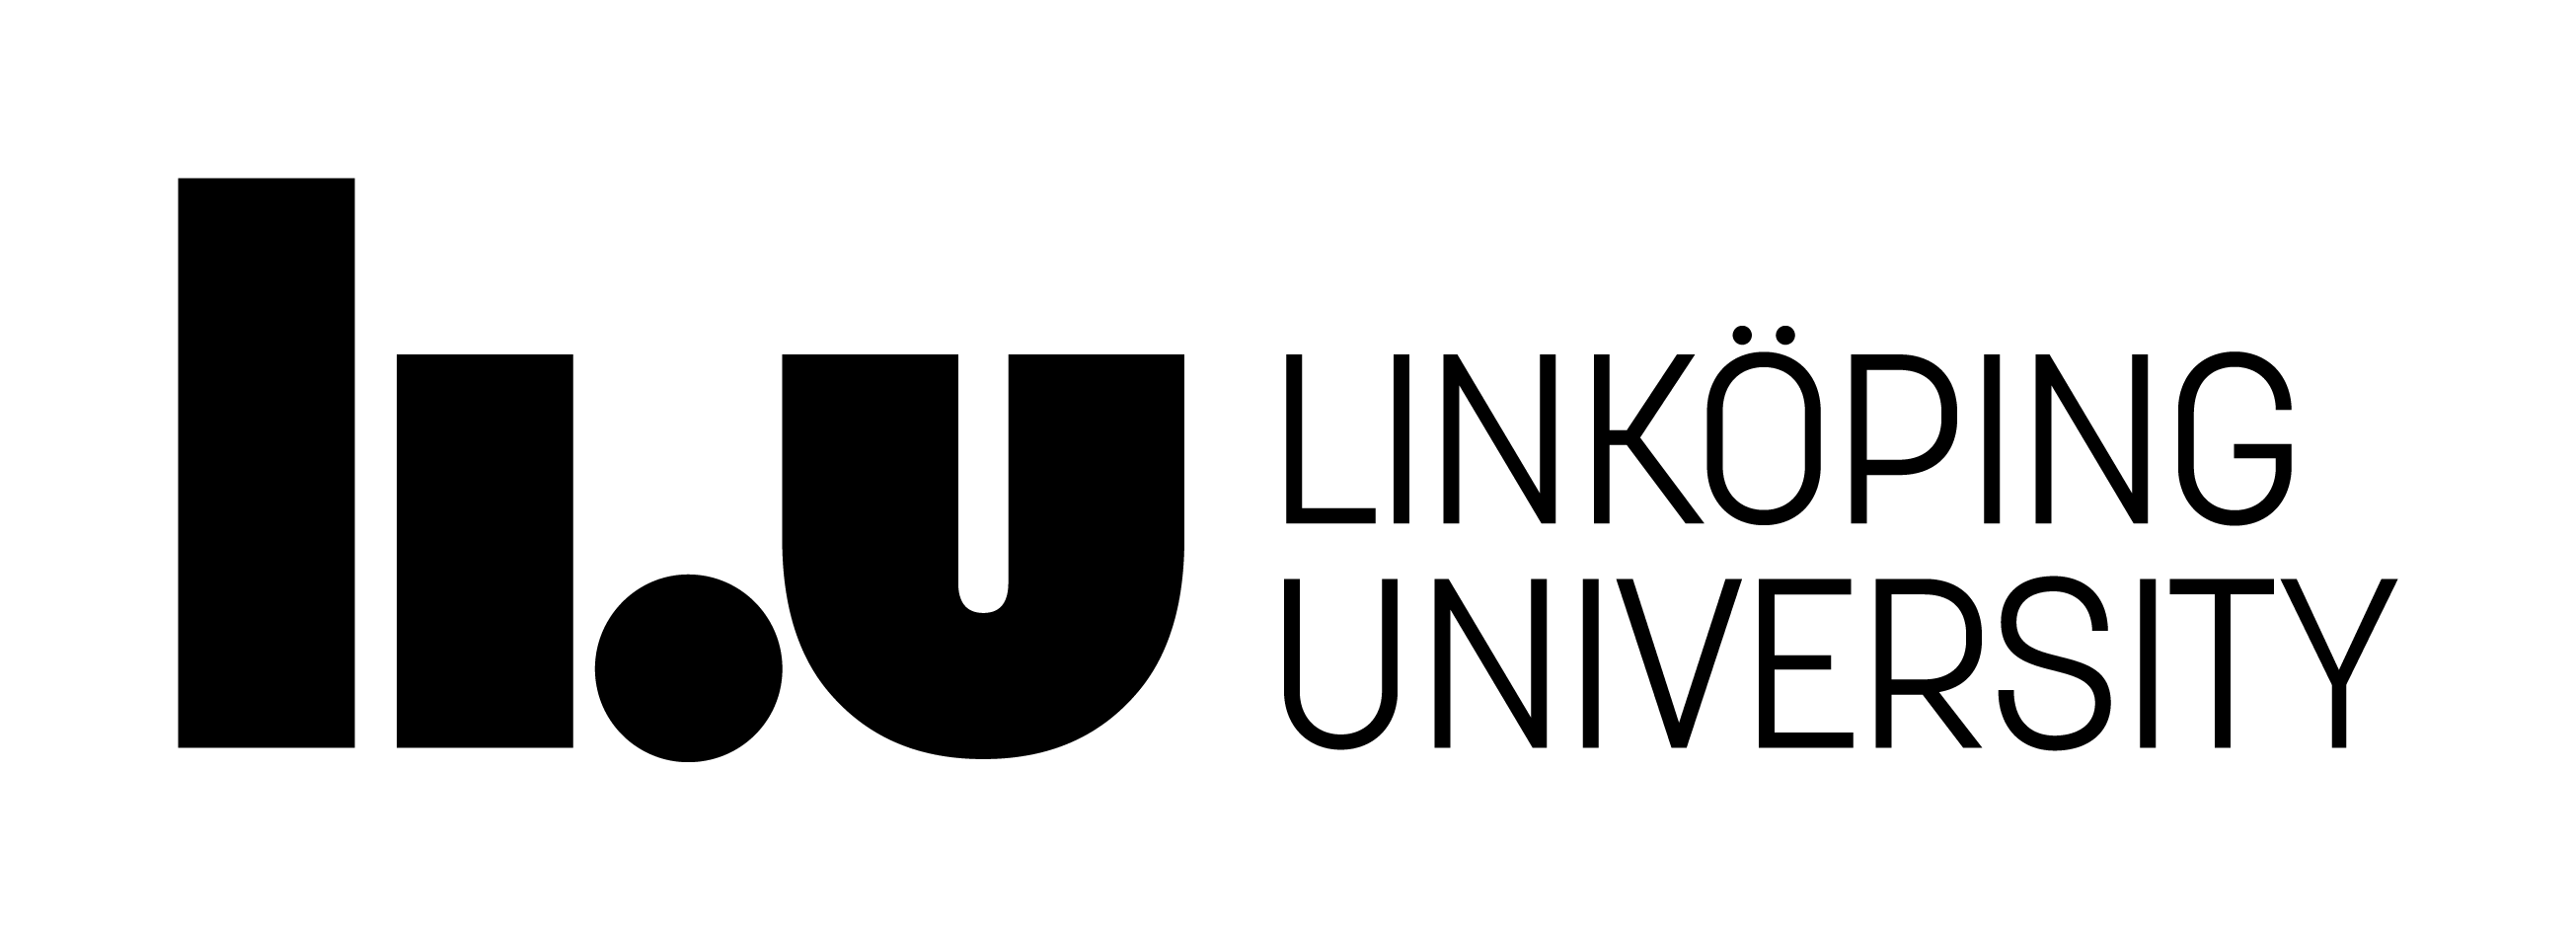
## Linkoping University: TDDC17 Artificial Intelligence
---



**Lab6 : Reinforcement Learning**


In this lab, we will implement one of the most successful deep reinforcement learning algorithms: the **Deep Q-Network (DQN)**. Our goal is to understand how DQN works and how to apply it to a classic control problem using the `gymnasium` environment.

DQN combines Q-learning with deep neural networks, enabling agents to learn control policies directly from high-dimensional inputs.

> In this exercise, we'll work with a simple environment (e.g., CartPole) to keep training time manageable. With more computational resources, DQN can be extended to handle more complex environments, such as Atari games.

By the end of this lab, you should:
- Understand the core components of DQN: experience replay, target network, and epsilon-greedy strategy.
- Implement and train a simple DQN agent.
- Evaluate and interpret the agent’s performance.

# Colab Configuration


In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.1
    Uninstalling gymnasium-1.2.1:
      Successfully uninstalled gymnasium-1.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

# Deep Q-Network (DQN) Overview

**Reference:**
[V. Mnih et al., "Human-level control through deep reinforcement learning", *Nature*, 518(7540):529–533, 2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

---

## Instability in Deep RL with Neural Networks

Using a neural network to approximate the action-value function ($Q$) often leads to **instability** due to:

- Correlated data from sequential observations
- Policy changes that shift the data distribution
- Strong correlation between action-values $Q$ and their target values $r + \gamma \max_{a'} Q(s', a')$

---

## DQN Stabilization Techniques

### 1. Experience Replay

To reduce correlation between consecutive experiences:

- Store transitions $(s, a, r, s')$ in a **replay buffer** $D$
- Sample batches **uniformly at random** from $D$:

  $$
  (s, a, r, s') \sim U(D)
  $$

This ensures more stable and i.i.d.-like training data.
*(See `sample_batch()` method in `ReplayBuffer` class for implementation details.)*

---

### 2. Fixed Q-Targets

To reduce target instability:

- Use a separate **target network** with parameters $\theta_i^-$
- Update the Q-network by minimizing:

  $$
  L_i(\theta_i) = \mathbb{E}_{(s,a,r,s') \sim U(D)} \left[ \left( r + \gamma \max_{a'} Q(s',a';\theta_i^-) - Q(s, a; \theta_i) \right)^2 \right]
  $$

- Sync $\theta_i^- \leftarrow \theta_i$ every **C steps** (e.g., C = 200 in CartPole-v0)

This helps stabilize learning by **decoupling the target from the rapidly-changing Q-values**.

---

### 3.  Gradient Clipping

The authors also found it helpful to clip the error term from the update $r + \gamma \max_{a'} Q(s', a'; \theta_i^-) - Q(s,a,;\theta_i)$ to be between -1 and 1. Because the absolute value loss function $|x|$ has a derivative of -1 for all negative values of x and a derivative of 1 for all positive values of x, clipping the squared error to be between -1 and 1 corresponds to using an absolute value loss function for errors outside of the (-1,1) interval. This form of error clipping further improved the stability of the algorithm.

---

## Summary Table

| Technique           | Purpose                                  |
|---------------------|-------------------------------------------|
| Experience Replay   | Break correlation between samples         |
| Fixed Q-Targets     | Reduce instability from changing targets  |
| Gradient Clipping   | Prevent large updates from outliers       |

---


In [2]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Replay Buffer

In reinforcement learning, the **Replay Buffer** stores experience tuples
$(s, a, r, s')$, allowing the agent to sample random batches for training.
Different data structures offer trade-offs in speed and ease of use.

---

### 🔹 1. `collections.deque`
### 🔹 2. `list`
### 🔹 3. `numpy array`

In this lab, we will implement a Replay Buffer using numpy.ndarray inspired by [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)


In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Network Architecture

We will use a **simple feedforward neural network** with:

- **3 fully connected (dense) layers**
- **ReLU activation** after the first two layers

This architecture is intentionally minimal, as we are using it to test **classical reinforcement learning methods** in simpler environments (e.g., CartPole, MountainCar, etc.).


In [4]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()
        # Task 1: Define the Neural Network

        #In this task, you will complete the definition of a simple feedforward neural network used by the DQN agent.
         #The network should take the state as input and output a Q-value for each possible action.
         #Hint: Use two hidden layers with ReLU activations. Each layer can have 128 units.

        self.layers = nn.Sequential(
            nn.Linear(in_dim,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,out_dim)# TODO <our code>
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

## DQN Agent Overview

Below is a summary of the core methods in the `DQNAgent` class:

| Method               | Description                                                  |
|----------------------|--------------------------------------------------------------|
| `select_action`      | Selects an action based on the current state.                |
| `step`               | Takes an action and observes the environment's response.     |
| `compute_dqn_loss`   | Calculates the DQN loss from a sampled batch.                |
| `update_model`       | Updates the Q-network using gradient descent.                |
| `target_hard_update` | Copies weights from the local model to the target model.     |
| `train`              | Trains the agent over a specified number of frames.          |
| `test`               | Evaluates the agent over a single episode (greedy policy).   |
| `plot`               | Plots the training progress (e.g., reward per episode).      |


In this task, you will implement a DQN agent that interacts with the environment and learns using experience replay and target networks.

You will need to complete parts of:
- `select_action`: Epsilon-greedy policy
- `update_model`: Sampling and training
- `_compute_dqn_loss`: Implementing the Bellman update

In [5]:

class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):

        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # TODO: Implement epsilon-greedy action selection
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()# TODO <your code>
        else:
            selected_action = self.dqn(torch.from_numpy(state).float().unsqueeze(0).to(self.device)).argmax(1).squeeze(0)# TODO <your code> hint: call dqn class and choose th action tht maximize Q
            selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples) # TODO <your code> Compute the minibatch loss using the DQN loss function

        self.optimizer.zero_grad()
        loss.backward()# TODO<your code> Apply a backward pass
        self.optimizer.step()# TODO <your code> Perform a gradient descent step

        return loss.item()

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)

                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)

        self.env.close()

    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True

        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        # reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
      """Compute the DQN loss using the Bellman update rule."""

      device = self.device

      # Unpack the batch and move to device
      state = torch.FloatTensor(samples["obs"]).to(device)
      next_state = torch.FloatTensor(samples["next_obs"]).to(device)
      action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
      reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
      done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

      # TODO: Compute current Q-values from the policy network
      # Hint: Use .gather(1, action) to get Q-values for the taken actions
      curr_q_value = self.dqn(state).gather(1,action)#<your code>

      # TODO: Compute the target Q-values using the target network
      # Hint: Use .max(dim=1, keepdim=True)[0] to get max Q-value per sample
      next_q_value = self.dqn_target(next_state).max(dim=1, keepdim=True)[0]#<your code>

      # TODO: Compute the target for current Q-values using the Bellman equation
      # Hint: target = reward + gamma* v(s_{t+1})*mask
      mask = 1 - done  # no future reward if episode is done
      target = reward + self.gamma * next_q_value * mask#<your code>

      # TODO: Compute the Huber loss (smooth L1) between current and target Q-values
      # Hint: Use smooth L1 loss (also known as Huber loss) for stability(F.smooth_l1_loss)
      loss = F.smooth_l1_loss(curr_q_value, target)#<your code>

      return loss


    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        losses: List[float],
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

## Environment: CartPole-v1

We will use the classic **CartPole-v1** environment for training and testing our DQN agent.

- It's a simple, well-known control task — ideal for testing basic reinforcement learning algorithms.
- The goal is to balance a pole on a moving cart by applying left or right forces.

🔗 You can view the source code and configuration details here:

- [📄 CartPole-v1 Environment Code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py)
- [⚙️ CartPole-v1 Configuration (line 91)](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py#L91)

---

Feel free to switch to more complex environments (e.g., LunarLander, Atari) as needed!


In [6]:
# environment
env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

In [7]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initialize

In [8]:
# parameters
num_frames = 20000
memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)

cuda


## Start Training

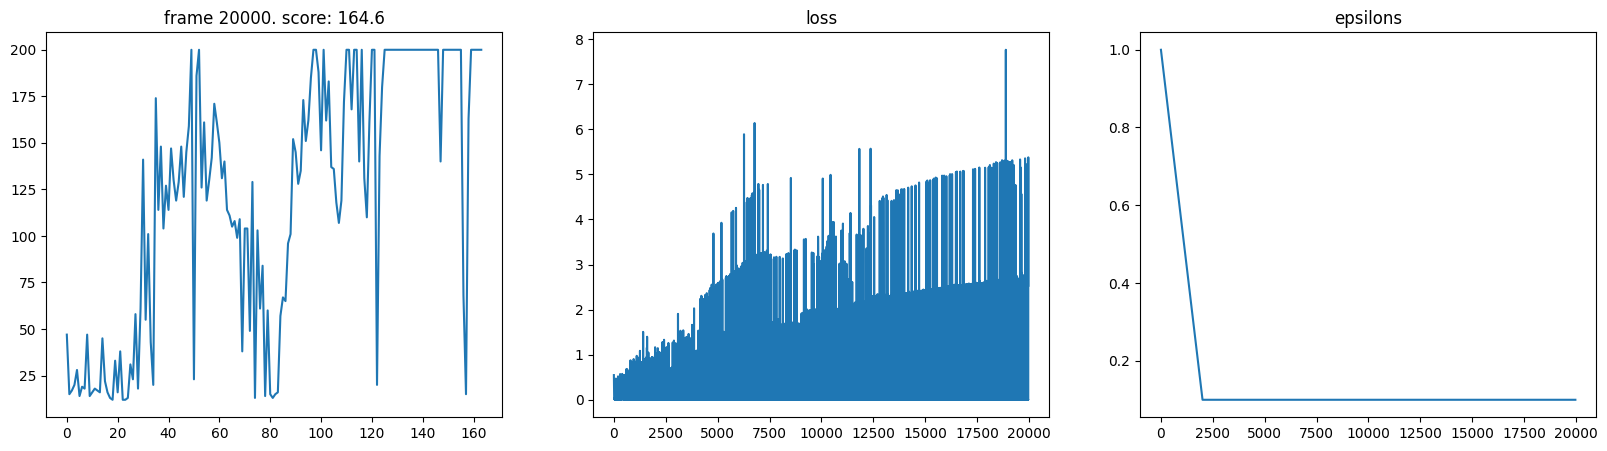

In [9]:
agent.train(num_frames)

## Post-Training Questions

Please answer the following questions based on your training results and what you've learned:



#### 1. **Did the agent successfully learn to solve the environment? How do you know?**
- Look at your reward curve. Is the score improving and stabilizing over time?



#### 2. **What does the epsilon value control?**
- Explain how it changes during training and why that’s important.



## Start Testing

Run the trained agent (1 episode).

In [10]:
video_folder = "videos/dqn"
agent.test(video_folder=video_folder)

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/videos/dqn/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/rl-video-episode-0.mp4
score:  200.0


## Play

In [11]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: /content/videos/dqn/rl-video-episode-0.mp4


## More: Extending DQN

If you want to explore more advanced variants of DQN, here are a couple of great next steps:

---


#### 1. **Double Q-Learning**

Helps reduce overestimation bias in Q-values.

- If you already have target networks, this is easy to implement!
- Instead of using `argmax` on the **target** network, you:
  - Use `argmax` on the **online** network to choose the action
  - Then use the **target** network to evaluate that action

> [Original Paper (van Hasselt et al., 2015)](https://arxiv.org/abs/1509.06461)




#### 2. **Dueling DQN Architecture**

The **Dueling DQN** architecture separates the estimation of:

- The **state-value function** \( V(s) \)
- The **advantage function** \( A(s, a) \)

This allows the network to learn which states are (or are not) valuable, **independently** of the chosen action.

> [Original Paper (Ziyu Wang et al., 2015)](https://arxiv.org/abs/1511.06581)


